In [71]:
import sys
import os
import pathlib
import glob
from typing import List
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from tqdm.auto import tqdm
from dateutil import parser
# from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from flexitext import flexitext
# import seaborn as sns
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl

In [72]:
%load_ext autoreload
%autoreload 2

from helper_functions import epa_taiwan_data_pipeline
from models import lstnet_gokul, lstnet_laigoukun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
# Set the random seed to 420
pl.seed_everything(420)

device = "cuda" if torch.cuda.is_available else "cpu"
device

Global seed set to 420


'cuda'

In [74]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"

# Data Loading and Preprocessing

- Import the data
- Feature engineering
- Turn the data into tensor

## Import the data

In [75]:
year = 2018
site_name = "Banqiao"
columns = ["SiteEngName","PM2.5","AMB_TEMP","CH4",'CO',"NMHC","read_time"]

# import data
pm25_df = epa_taiwan_data_pipeline.import_epa_data(site_name=site_name, year=year)[columns]

# basic preprocessing
pm25_df = epa_taiwan_data_pipeline.standardize_df(pm25_df)

## Feature engineering

In [76]:
train_split = 0.6

train_data = pm25_df.iloc[:int(len(pm25_df)*train_split),:]
print(f"All data length:{len(pm25_df)} \nTrain data length:{len(train_data)}")
train_data.tail(2)

All data length:8760 
Train data length:5256


,siteengname,pm2.5,amb_temp,ch4,co,nmhc,read_time
399305,Banqiao,8.0,30.2,1.8,0.30,0.08,2018-08-07 22:00:00
399381,Banqiao,9.0,29.9,1.8,0.23,0.06,2018-08-07 23:00:00


In [77]:
normalized_columns = ['pm2.5', 'amb_temp', 'ch4', 'co', 'nmhc']
normalized_column_names = []
for column in normalized_columns:
    normalized_column_name = column + '_normalized'
    normalized_column_names.append(normalized_column_name)
    train_data[normalized_column_name] = (train_data[column] - train_data[column].min()) / (train_data[column].max() - train_data[column].min())

## Convert to tensor

In [78]:
# verify dataset instances
temp_train_dataset = epa_taiwan_data_pipeline.AqiDataset(train_data, history_len=48, col_names=[normalized_column_names[0]], device=None)
# temp_train_dataset = epa_taiwan_data_pipeline.AqiDataset(train_data, history_len=48, col_names=[normalized_column_names[0]], device=device)
print(len(temp_train_dataset))
x, y = temp_train_dataset[0]
print(x.shape, y.shape)

5208
torch.Size([48, 1]) torch.Size([1])


In [79]:
# train data_loader
temp_train_data_loader = DataLoader(temp_train_dataset, batch_size=4)
X, Y = next(iter(temp_train_data_loader))
print(X.shape, Y.shape)
print(X.is_cuda, Y.is_cuda)

torch.Size([4, 48, 1]) torch.Size([4, 1])
False False


# Training Pipeline

- Prepare the model
- Initiate loss and optimization function
- Training process
- Plot the loss curve

In [94]:
# test the model
temp_model = lstnet_gokul.LSTNet(ar_window_size=24, num_features=1, recc1_out_channels=64, conv1_out_channels=32)#.to(device)
# next(temp_model.parameters()).device

In [95]:
for X, Y in temp_train_data_loader:
    print(X.shape)
    out = temp_model(X)
    print(Y.shape, out.shape)
    break

torch.Size([4, 48, 1])
torch.Size([4, 1]) torch.Size([4, 1])


In [82]:
history_len = 48
batch_size = 8 

epochs = 10

lr = 1e-3
weight_decay = 0.01

In [83]:
criterion = nn.MSELoss()
optimizer = optim.Adam(temp_model.parameters(), lr=lr, weight_decay=weight_decay)

In [41]:
train_loss_list = []

if os.path.exists(rf'testing_log\temp_Running_Loss_{epochs}_epoch.txt'):
    os.remove(rf'testing_log\temp_Running_Loss_{epochs}_epoch.txt')

if os.path.exists(rf'testing_log\temp_Epoch_Loss_{epochs}_epoch.txt'):
    os.remove(rf'testing_log\temp_Epoch_Loss_{epochs}_epoch.txt')
        
for epoch in tqdm(range(epochs)):
    epoch_loss_train = 0
    for i, batch in enumerate(temp_train_data_loader, start=1):
        X, Y = batch
        optimizer.zero_grad()
        Y_pred = temp_model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()

        with open(rf'testing_log\temp_Running_Loss_{epochs}_epoch.txt', 'a+') as file:
            file.write(f'{loss.item()}\n')
        epoch_loss_train += loss.item()

    epoch_loss_train = epoch_loss_train / len(temp_train_data_loader)
    train_loss_list.append(epoch_loss_train)

    with open(rf'testing_log\temp_Epoch_Loss_{epochs}_epoch.txt', 'a+') as file:
        file.write(f'{epoch_loss_train}\n')

  0%|          | 0/10 [00:00<?, ?it/s]

In [42]:
model_name = f"test_LSTNet_uni-E{epochs}"
model_path = rf"saved_models\{model_name}.pth"

if not os.path.exists(model_path):
    torch.save(temp_model.state_dict(), model_path)

In [43]:
epoch_loss = pd.read_table(rf'testing_log\temp_Epoch_Loss_{epochs}_epoch.txt', header=None)
running_loss = pd.read_table(rf'testing_log\temp_Running_Loss_{epochs}_epoch.txt', header=None)

<Axes: >

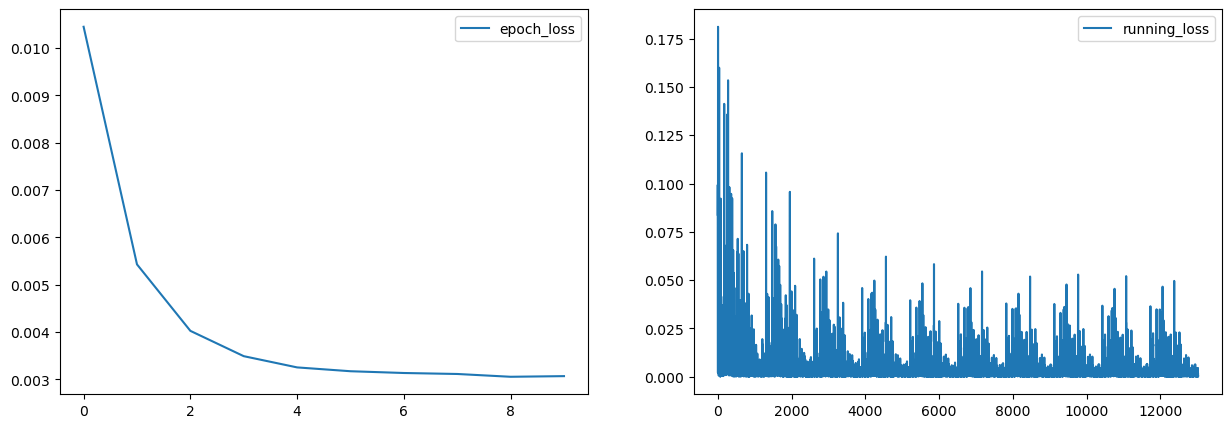

In [44]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

epoch_loss.plot(
    y = 0,
    label = "epoch_loss",
    ax=ax[0]
)

running_loss.plot(
    y = 0,
    label = "running_loss",
    ax=ax[1]
)

In [84]:
test_data = pm25_df.iloc[int(len(pm25_df)*train_split):,:]
print(f"All data length:{len(pm25_df)} \nTrain data length:{len(test_data)}")
test_data.head()

All data length:8760 
Train data length:3504


,siteengname,pm2.5,amb_temp,ch4,co,nmhc,read_time
399457,Banqiao,9.0,29.8,1.8,0.18,0.05,2018-08-08 00:00:00
399533,Banqiao,7.0,29.8,1.8,0.15,0.07,2018-08-08 01:00:00
399609,Banqiao,7.0,29.6,1.8,0.15,0.13,2018-08-08 02:00:00
399685,Banqiao,7.0,29.3,1.9,0.15,0.15,2018-08-08 03:00:00
399761,Banqiao,4.0,28.9,1.9,0.15,0.16,2018-08-08 04:00:00


In [85]:
test_dataset = epa_taiwan_data_pipeline.AqiDataset(test_data, history_len=history_len, col_names=[normalized_column_names[0]], device=None)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [86]:
def min_max_df_norm(
    df:pd.DataFrame,
    target:str='pm2.5',
    cols:List=['pm2.5', 'amb_temp', 'ch4', 'co', 'nmhc']
    ) -> pd.DataFrame:
    """do a normalization to a dataframe

    Args:
        df (pd.DataFrame): the dataframe to be normalized
        target (str, optional): the target to be predicted later. Defaults to 'pm2.5'.
        cols (List, optional): columns that will be normalized. Defaults to ['pm2.5', 'amb_temp', 'ch4', 'co', 'nmhc'].

    Returns:
        Tuple[pd.DataFrame, float, float]: return the normalized df and min and max value of the target
    """
    for column in cols:
        normalized_column_name = column + '_normalized'
        df[normalized_column_name] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
        max_column_name = column + '_max'
        df[max_column_name] = df[column].max()
        min_column_name = column + '_min'
        df[min_column_name] = df[column].min()

    return df

In [87]:
test_data = min_max_df_norm(test_data)
test_min_pm, test_max_pm = test_data["pm2.5"].min(), test_data["pm2.5"].max()

In [91]:
model = lstnet_gokul.LSTNet(7, 1, 64, 32)
model.load_state_dict(torch.load(model_path))
model.eval()

LSTNet(
  (conv1): Conv2d(1, 32, kernel_size=(7, 1), stride=(1, 1))
  (recc1): GRU(32, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=176, out_features=1, bias=True)
  (ar): Linear(in_features=7, out_features=1, bias=True)
)

In [92]:
for i, batch in tqdm(enumerate(test_data_loader, start=1),leave=False, total=len(test_data_loader)):
    X, Y = batch
    Y_pred = temp_model(X).detach().numpy()
    if i == 1:
        predictions = Y_pred
    else:
        predictions = np.concatenate((predictions, Y_pred), axis=0)

predictions = predictions * (test_max_pm - test_min_pm) + test_min_pm

columns = ['pm2.5']
predictions = pd.DataFrame(predictions, columns=columns)
predictions['read_time'] = test_data.reset_index()['read_time']
# print(predictions.shape)
# predictions.head()

  0%|          | 0/432 [00:00<?, ?it/s]

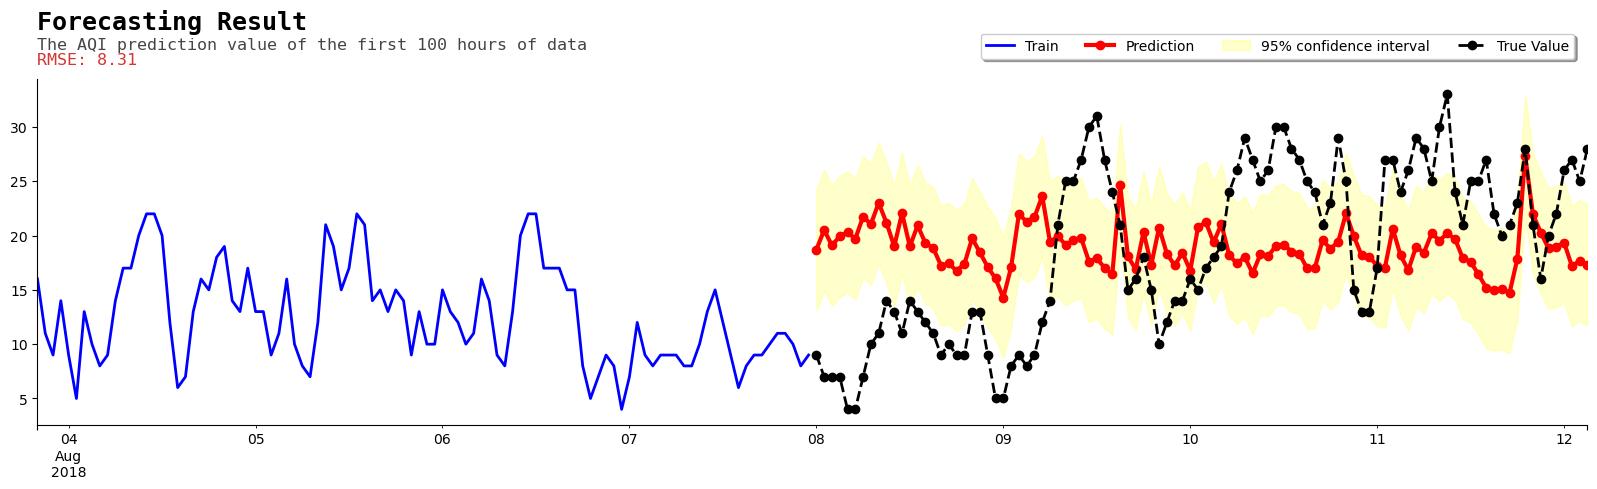

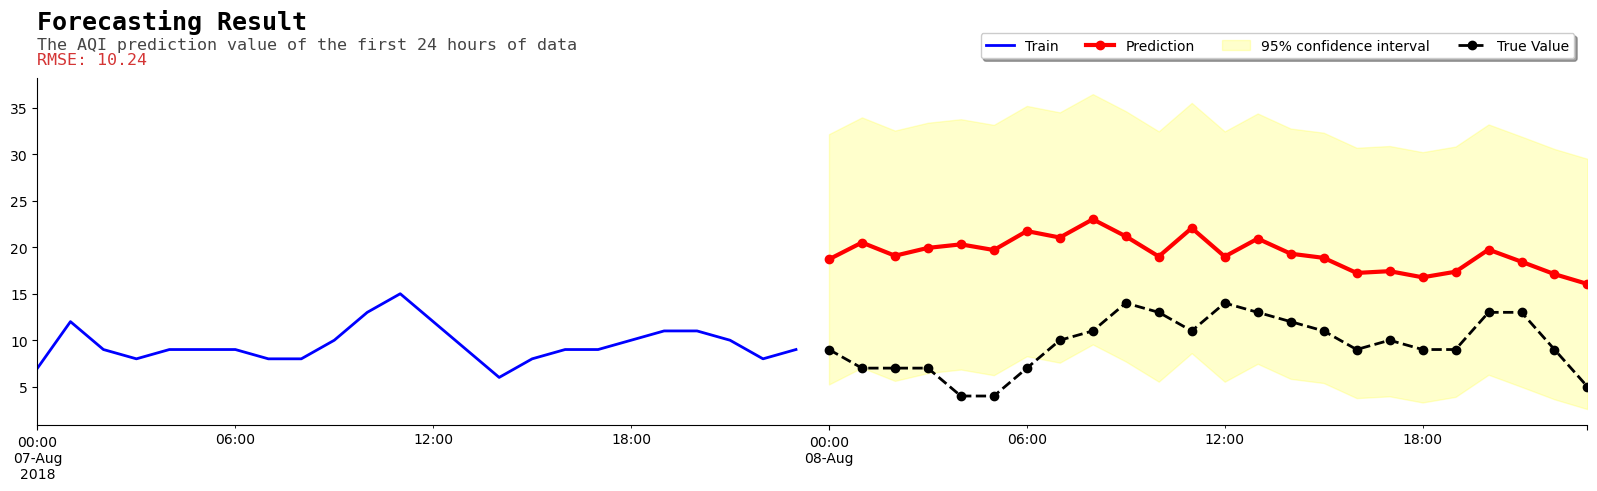

In [93]:
for length in [100, 24]:
    temp_train = train_data[['pm2.5', 'read_time']].reset_index().tail(length).reset_index().drop(columns=["index", "level_0"]).rename(columns={'pm2.5':'pm2.5_train'})
    temp_test = test_data[['pm2.5', 'read_time']].reset_index().head(length).reset_index().drop(columns=["index", "level_0"]).rename(columns={'pm2.5':'pm2.5_test'})
    temp_pred = predictions.head(length).rename(columns={'pm2.5':'pm2.5_prediction'})
    
    temp_pred_test = pd.merge(temp_pred, temp_test, on='read_time', how='inner')
    
    # Calculate MSE and RMSE
    temp_pred_test['squared_error'] = (temp_pred_test['pm2.5_test'] - temp_pred_test['pm2.5_prediction']) ** 2
    mse = temp_pred_test['squared_error'].mean()
    rmse = (temp_pred_test['squared_error'].mean())**.5

    fig, ax = plt.subplots(figsize = (20,5))
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.xlabel("")
    
    temp_train.plot(
        x="read_time",
        y="pm2.5_train",
        ax=ax,
        label="Train",
        color="blue",
        lw=2
        )

    temp_pred_test.plot(
        x="read_time",
        y="pm2.5_prediction",
        ax=ax,
        label="Prediction",
        color="red",
        marker="o",
        lw=3
        )
    
    # Define the confidence interval
    ci = 0.95 * (temp_pred_test['squared_error'].std() / np.sqrt(len(temp_pred_test)))
    
    ax.fill_between(
        temp_pred_test.read_time.values, 
        (temp_pred_test["pm2.5_prediction"]-ci).to_numpy(), 
        (temp_pred_test["pm2.5_prediction"]+ci).to_numpy(), 
        color='yellow', alpha=0.2,
        label=r"95% confidence interval"
        )
    
    temp_pred_test.plot(
        x="read_time",
        y="pm2.5_test",
        linestyle='--',
        ax=ax,
        label="True Value",
        color="black",
        marker="o",
        lw=2
        )
    
    title = "<name:monospace, size:18><weight:bold>Forecasting Result</></>"
    flexitext(0, 1.20, title, va="top", ax=ax)

    subtitle = (f"<name:monospace, size:12, color:#454545>The AQI prediction value of the first {length} hours of data\n<color: #d43535>RMSE: {rmse:.2f}</></>")
    flexitext(0, 1.12, subtitle, va="top", ax=ax)
    
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(
        loc='upper center', 
        bbox_to_anchor=(0.8, 1.15), # original (0.5, -0.05)
        fancybox=True, shadow=True, ncol=5
        )
    
    plt.xlabel(None)
    
    # plt.savefig(
    #     rf'images\prediction_result_{length}_hour.png',
    #     bbox_inches='tight'
    #     )

# Experimentation

- Prepare different scenarios
    - [x] number of epochs --> [50, 100, 200]
    - [x] lookback periods --> [24, 24x2, 24x7, 24x30] (history_len)
    - [x] batch size --> [16, 64, 128]
    - [x] loss function --> [MSE (nn.MSELoss()), MAE (nn.L1Loss()), Huber Loss (nn.SmoothL1Loss())]
- Log the experiment
- Monitor the result with MLFlow or ~~tensorboard~~

In [2]:
epochs = [10, 20, 50]
lookback_periods = [24//2, 24, 24*2, 24*7]
batch_sizes = [16, 64, 128]
# loss_functions = [nn.MSELoss(), nn.SmoothL1Loss()]

In [4]:
for epoch in epochs:
    for lookback in lookback_periods:
        for batch_size in batch_sizes:
            model_name = f"LSTNET_{epoch}E_{lookback}W_{batch_size}B"
            print(model_name)
            

In [19]:
model_testing = lstnet_gokul.LSTNet(7, 1, 64, 32)

# Inferencing

- Load the best model
- Prepare the test data
- Save the result

# Deployment